## Cost of living

In [1]:
import numpy as np
from pyclustertend import hopkins ## the hopkins test
from fcmeans import FCM
from matplotlib import pyplot as plt
def cluster_for_multiple(df,max_clusters):
    n_clusters_list = np.array(list(range(2,max_clusters)))
    models = list()
    for n_clusters in n_clusters_list:
        fcm = FCM(n_clusters)
        fcm.fit(df.values)
        models.append(fcm)
#         print(n_clusters,fcm.partition_coefficient,fcm.partition_entropy_coefficient)
    return models

In [2]:
from pandas import DataFrame, MultiIndex
def getPC(model):
    return model.partition_coefficient
def getPAC(model):
    return model.partition_entropy_coefficient
def process_things2(df,max_clusters):
    standardModels = cluster_for_multiple(df,max_clusters)
    meanModels = cluster_for_multiple(df.mean(axis=1).to_frame(),max_clusters)
    diffModels = cluster_for_multiple(df.diff(axis=1).drop("2010",axis=1),max_clusters)
    pct_changeModels = cluster_for_multiple(df.pct_change(axis=1).drop("2010",axis=1),max_clusters)
    indices = MultiIndex.from_product((range(2,max_clusters),(["pc","pec"])), names=["clusters", "measure"])
    models = [standardModels,meanModels,diffModels,pct_changeModels]
    methods = [getPC,getPAC]
    data = [[method(model[index])   for model in models]  for index in range(max_clusters-2) for method in methods]
    df = DataFrame(data,columns=["standard", "mean","diff","pct_change"], index=indices)
    return df,models                                  

In [3]:
from pandas import read_csv
filename = 'dataset//cost_of_living.csv'
df_cost_of_living = read_csv(filename,index_col="Country")
df_cost_of_living.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country,,,,,,,,,,,
Argentina,1287.8540,1567.5980,1938.3650,1855.1085,2003.9330,2250.2455,2134.153345,2162.854675,1845.922275,1547.585985,1450.537395
Australia,2305.9525,3402.0115,3497.3400,3606.2805,3505.2375,3031.5370,3015.473135,3013.260195,3118.820875,3015.915325,3029.782315
Austria,2098.4985,2771.5665,2395.3730,2461.0660,2535.7345,2414.0015,2746.560665,2763.594395,2892.079440,2807.800890,2715.892825
Belgium,2467.6735,3089.2735,2618.6360,2795.8555,3031.6935,2755.3645,2950.407795,2784.550510,3012.334075,2876.052530,2974.076965
Bosnia And Herzegovina,1201.1620,1351.2165,1291.5925,1345.5085,1383.9850,1215.0130,1374.416230,1362.515830,1452.223765,1488.702065,1454.164550


Hopkins test, is there sense to cluster?

In [4]:
X = df_cost_of_living.values
hopkins(X,X.shape[0])
# pd.get_dummies

0.13885750966553576

yes there is

In [5]:
df,models = process_things2(df_cost_of_living,10)
df.head(30)

standard        mean        diff  pct_change
clusters measure                                                
2        pc         0.856584   0.8827389  0.61777014   0.6109518
         pec      0.35919487   0.2929653    0.813488  0.82325006
3        pc       0.72212535   0.7988402    0.434489  0.42926747
         pec      0.71680206  0.52546096    1.365395   1.3758024
4        pc       0.72175384  0.81655127   0.3375636  0.33038545
         pec      0.76306295  0.50418293   1.7586854   1.7828375
5        pc        0.6550746   0.7815296  0.27138168   0.2677955
         pec       0.9718569   0.6193998   2.0806532   2.0995593
6        pc       0.56748265   0.7685897  0.23751138  0.22755647
         pec       1.2418491   0.6823853   2.3116913   2.3542354
7        pc        0.5667242   0.7854924  0.20657438  0.19847187
         pec       1.3024033   0.6580537   2.5341647   2.5718281
8        pc        0.5260627    0.785724  0.19145572  0.17576733
         pec       1.4560901  0.66154087   2.6908207   2.7631242
9        pc       0.52199155   0.8186208  0.17730701  0.15746774
         pec       1.5059723  0.56982315   2.8467057   2.9254787

2,3,4 clusters looks good, we need 4 then we will take it

In [6]:
cost_of_living_model = models[0][2]

Wzór na dzielone pola: 1/(best_standard_model.n_clusters+1)

In [13]:
cost_of_living_groups = np.array(cost_of_living_model.u > 1/(cost_of_living_model.n_clusters+1))
cost_of_living_labels = DataFrame(cost_of_living_groups,columns=["group "+str(i+1) for i in range(cost_of_living_groups.shape[1])], index=df_cost_of_living.index)
cost_of_living_labels[cost_of_living_labels.sum(axis=1)>1].head(50)

,group 1,group 2,group 3,group 4
Country,,,,
Brazil,True,True,False,False
China,True,True,False,False
Czech Republic,True,True,False,False
Greece,True,False,True,False
Hungary,True,True,False,False
Kazakhstan,True,True,False,False
Malta,True,False,True,False
Puerto Rico,True,False,True,False
Qatar,True,False,True,False


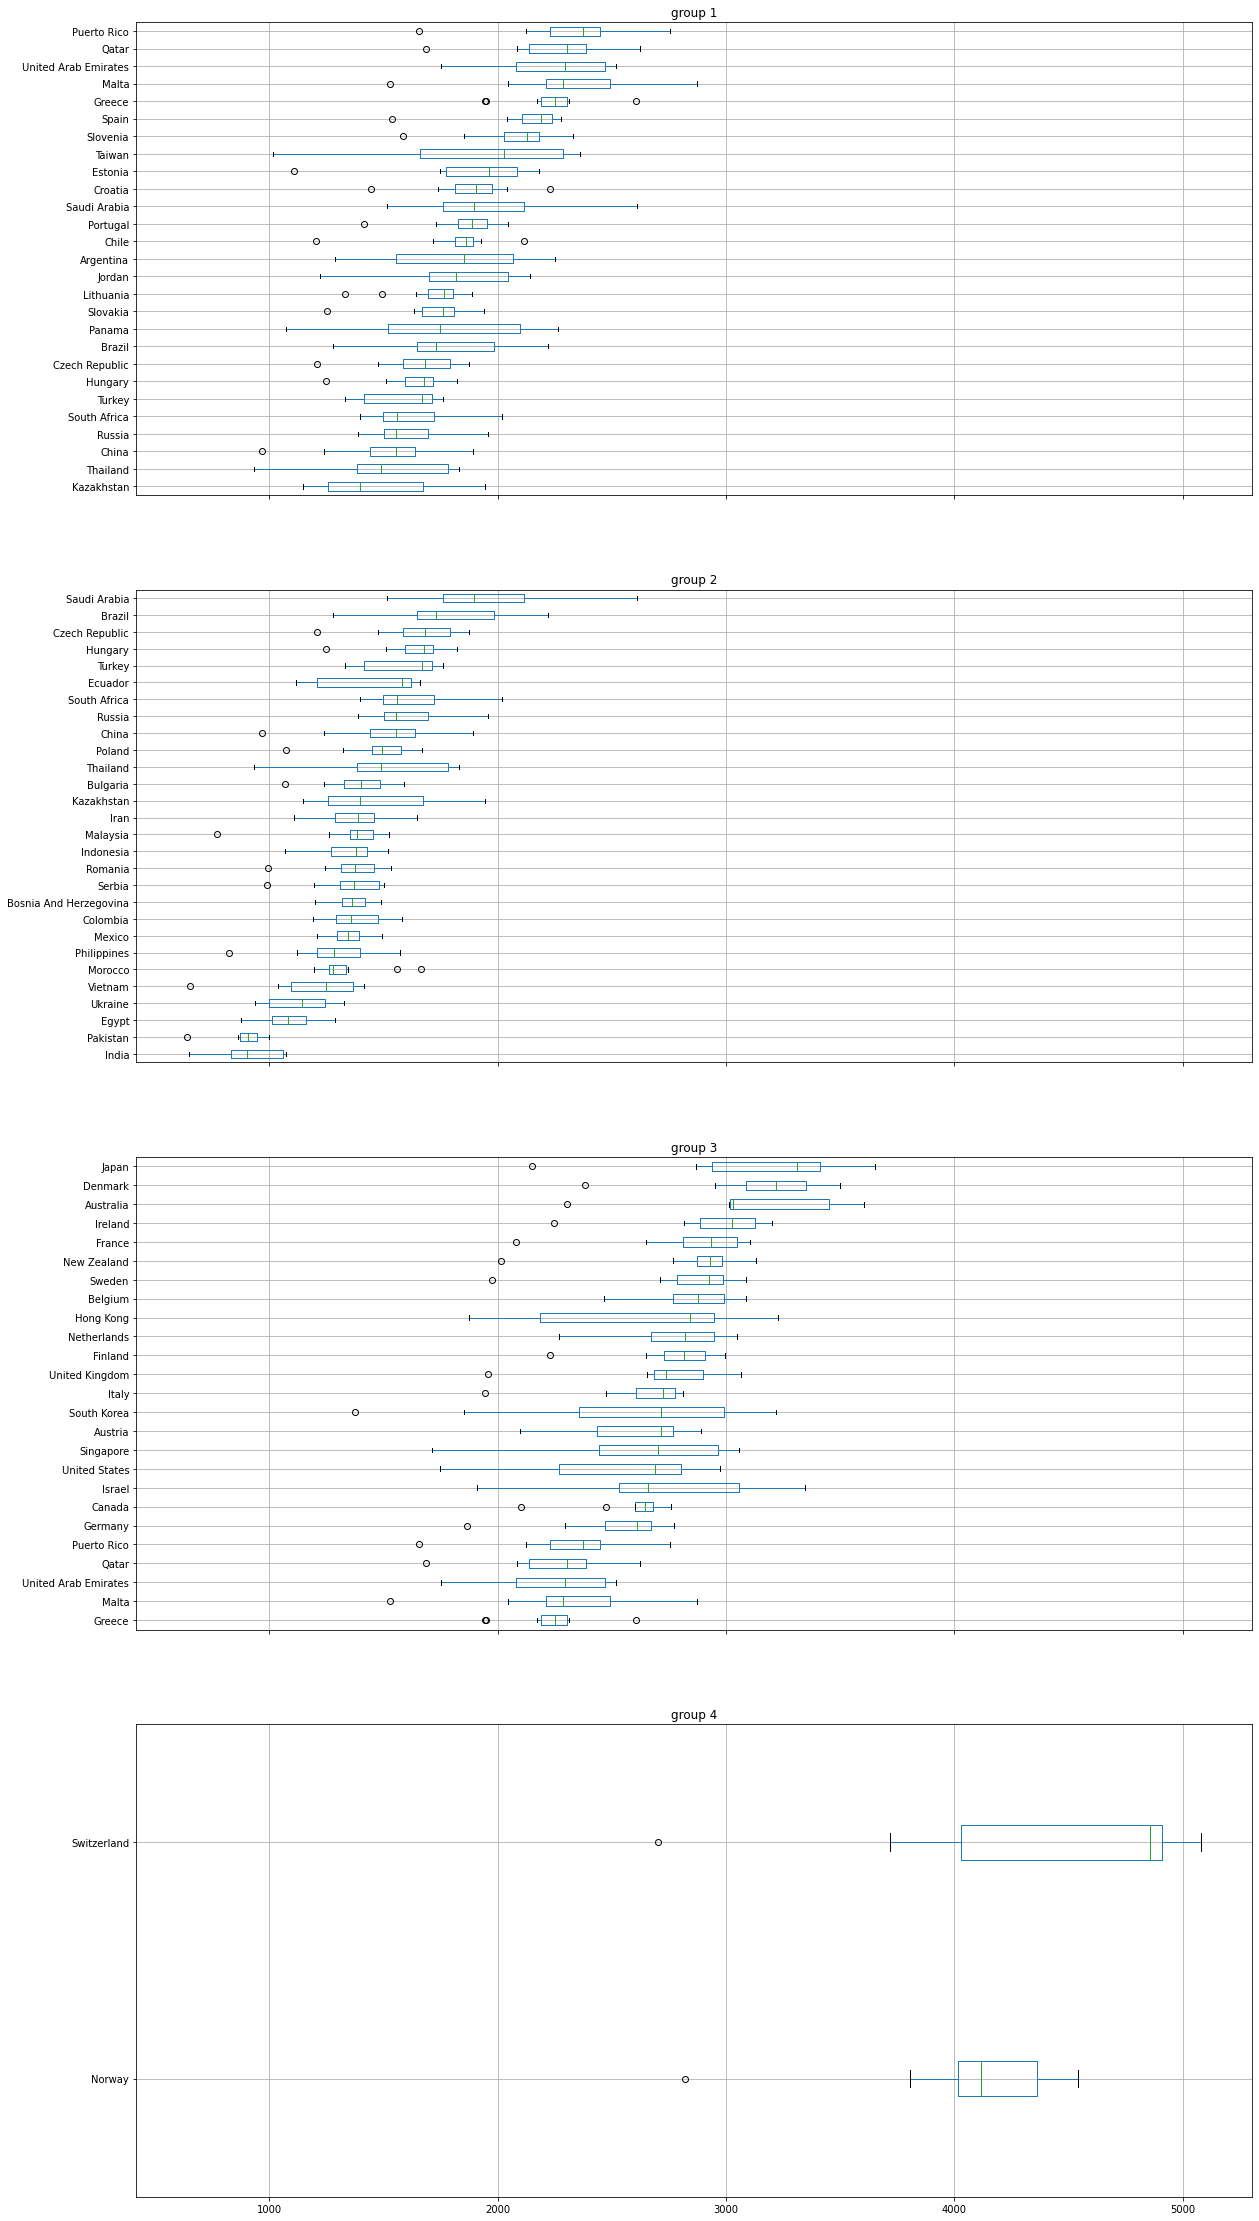

In [11]:
fig, axes = plt.subplots(cost_of_living_labels.columns.shape[0], figsize=(20,40),sharex=True)

for column,ax in zip(cost_of_living_labels.columns, axes):
    data = df_cost_of_living[cost_of_living_labels[column]]
    sort_by_mean = data.median(axis=1).sort_values()
    ax.title.set_text(column)
    data.reindex(sort_by_mean.index, axis=0).T.boxplot(vert=False,ax=ax)

In [12]:
cost_of_living_labels.to_csv("dataset//cost_of_living_labels.csv")

## Wealth factor

In [16]:
filename = 'dataset//wealth_factor.csv'
df_wealth_factor = read_csv(filename,index_col=["Country","Field"])
df_wealth_factor.head()

2010  \
Country Field                                                          
Austria B. Mining and quarrying                             1.955250   
        C. Manufacturing                                    1.741093   
        D. Electricity; gas, steam and air conditioning...  2.522561   
        E. Water supply; sewerage, waste management and...  1.533878   
        F. Construction                                     1.540196   

                                                                2011  \
Country Field                                                          
Austria B. Mining and quarrying                             1.778384   
        C. Manufacturing                                    1.516222   
        D. Electricity; gas, steam and air conditioning...  2.282622   
        E. Water supply; sewerage, waste management and...  1.238992   
        F. Construction                                     1.165168   

                                                                2012  \
Country Field                                                          
Austria B. Mining and quarrying                             1.967915   
        C. Manufacturing                                    1.670233   
        D. Electricity; gas, steam and air conditioning...  2.552550   
        E. Water supply; sewerage, waste management and...  1.365044   
        F. Construction                                     1.268500   

                                                                2013  \
Country Field                                                          
Austria B. Mining and quarrying                             2.014517   
        C. Manufacturing                                    1.735520   
        D. Electricity; gas, steam and air conditioning...  2.595184   
        E. Water supply; sewerage, waste management and...  1.413347   
        F. Construction                                     1.289226   

                                                                2014  \
Country Field                                                          
Austria B. Mining and quarrying                             1.840500   
        C. Manufacturing                                    1.602644   
        D. Electricity; gas, steam and air conditioning...  2.240771   
        E. Water supply; sewerage, waste management and...  1.452806   
        F. Construction                                     1.466427   

                                                                2015  \
Country Field                                                          
Austria B. Mining and quarrying                             1.792961   
        C. Manufacturing                                    1.531441   
        D. Electricity; gas, steam and air conditioning...  2.274178   
        E. Water supply; sewerage, waste management and...  1.248317   
        F. Construction                                     1.146739   

                                                                2016  \
Country Field                                                          
Austria B. Mining and quarrying                             1.566115   
        C. Manufacturing                                    1.372666   
        D. Electricity; gas, steam and air conditioning...  2.046909   
        E. Water supply; sewerage, waste management and...  1.116753   
        F. Construction                                     1.027285   

                                                                2017  \
Country Field                                                          
Austria B. Mining and quarrying                             1.756086   
        C. Manufacturing                                    1.415580   
        D. Electricity; gas, steam and air conditioning...  2.092098   
        E. Water supply; sewerage, waste management and...  1.153147   
        F. Construction                                     1.064035   

                        

In [38]:
df_wealth_factor_total = df_wealth_factor[df_wealth_factor.index.map(lambda x: x[1]=="Total")].reset_index(level=1,drop=True)
df_wealth_factor_total.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Country,,,,,,,,,,
Austria,1.610318,1.214385,1.328570,1.356144,1.470095,1.194539,1.066377,1.099188,1.130287,1.135102
Canada,1.633002,1.404459,1.412510,1.344408,1.330145,1.200633,1.181062,1.288202,1.205984,1.236199
Colombia,0.302107,0.326338,0.323344,0.359604,0.350767,0.289227,0.286670,0.301525,0.306490,0.320278
Germany,2.047452,2.022286,2.099457,2.017790,1.537727,1.808020,1.727878,1.777219,1.820677,1.818674
Ecuador,0.309987,0.346973,0.348286,0.351477,0.389123,0.315953,0.301856,0.308432,0.310075,0.323835


In [39]:
X = df_wealth_factor_total.values
hopkins(X,X.shape[0])

0.18628296316921056

In [40]:
df,models = process_things2(df_wealth_factor_total,20)
df.head(50)

standard        mean        diff  pct_change
clusters measure                                                
2        pc        0.8817568  0.89179814   0.7287983   0.9553219
         pec       0.3003207  0.27452666  0.61195195  0.14177337
3        pc       0.84855163   0.8762509  0.58578986   0.5872665
         pec      0.43434492  0.35338968   1.0359589  0.90490997
4        pc        0.8220539  0.86108524   0.5970439   0.4680164
         pec      0.51455826  0.39891556    1.101547    1.312968
5        pc       0.79160416  0.84182394  0.54569703  0.45104304
         pec      0.63500476  0.46804577   1.3383868   1.5018047
6        pc        0.8055035  0.89484483  0.47563863  0.36383578
         pec      0.62898797  0.35064682   1.6070435   1.8325936
7        pc        0.7665094   0.8683224   0.4935587  0.42517352
         pec      0.72336346   0.4145686   1.5968632   1.7917836
8        pc         0.777855   0.8741972  0.50967747  0.42139187
         pec       0.7310289  0.38694143   1.6184895   1.8303763
9        pc        0.7762501   0.8542288   0.5291075  0.48293528
         pec       0.7310966  0.48796234   1.6242924   1.7737474
10       pc       0.76379704  0.86230737  0.57131314   0.5387877
         pec      0.76232195  0.46940485   1.5022216    1.635655
11       pc       0.76149404   0.9118279    0.584057   0.5745526
         pec      0.76723343   0.2920105   1.4797581   1.5667961
12       pc         0.760384  0.95716447  0.64258635   0.6260097
         pec       0.7954366   0.1557605   1.3316683   1.3928111
13       pc        0.8060729   0.9468748    0.708985   0.6656355
         pec       0.6540326   0.1754169    1.079283   1.3115549
14       pc        0.8765503   0.9229249  0.72908545  0.72166425
         pec       0.4110643  0.25467116   1.0503626   1.0784297
15       pc        0.8537491         nan   0.7692872   0.7692653
         pec       0.5078301         nan  0.90550244  0.91372263
16       pc        0.8836191  0.94369423   0.8199156   0.8131232
         pec      0.39181626  0.18753937   0.7055081  0.76189077
17       pc        0.8823271         nan   0.8675699   0.8631827
         pec      0.40736786         nan   0.5020178   0.5467437
18       pc        0.9395665         nan  0.90761316   0.9064153
         pec      0.21606481         nan  0.37499818  0.39253074
19       pc        0.9765288         nan   0.9476223    0.952072
         pec      0.08568415         nan  0.22875161   0.2114042

In [41]:
wealth_factor_total_model = models[0][2]

In [42]:
wealth_factor_total_groups = np.array(wealth_factor_total_model.u > 1/(wealth_factor_total_model.n_clusters+1))
wealth_factor_total_labels = DataFrame(wealth_factor_total_groups,columns=["group "+str(i+1) for i in range(wealth_factor_total_groups.shape[1])], index=df_wealth_factor_total.index)
wealth_factor_total_labels[wealth_factor_total_labels.sum(axis=1)>1].head(50)

,group 1,group 2,group 3,group 4
Country,,,,
Japan,False,False,True,True
Norway,True,False,True,False
Panama,False,True,False,True
United States,True,False,True,False


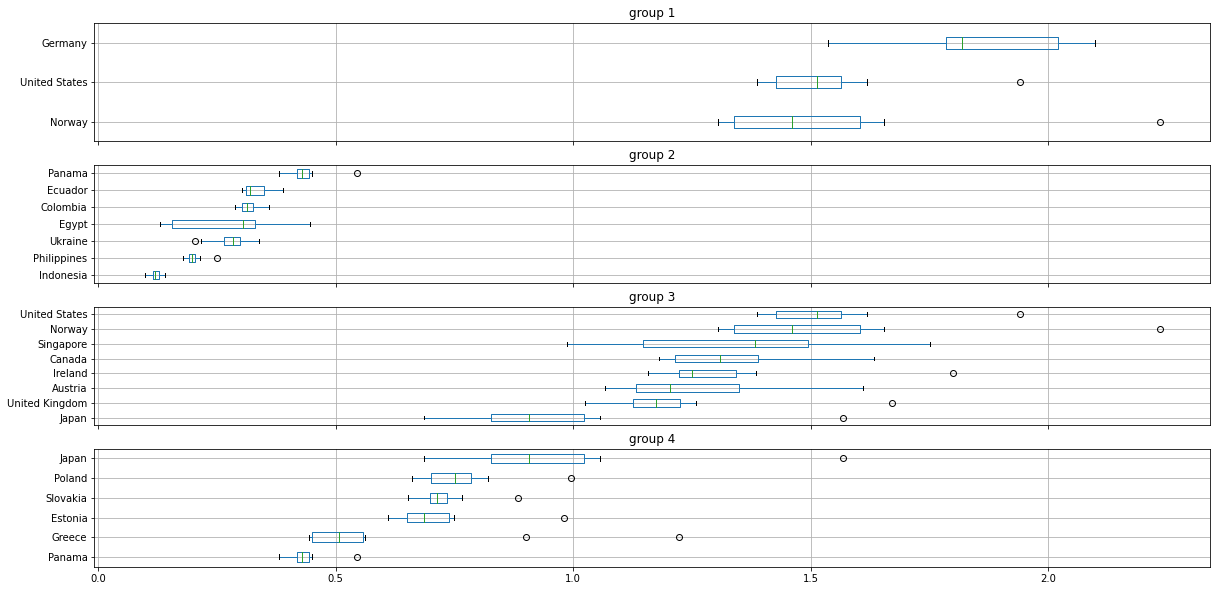

In [46]:
fig, axes = plt.subplots(wealth_factor_total_labels.columns.shape[0], figsize=(20,15),sharex=True)

for column,ax in zip(wealth_factor_total_labels.columns, axes):
    data = df_wealth_factor_total[wealth_factor_total_labels[column]]
    sort_by_mean = data.median(axis=1).sort_values()
    ax.title.set_text(column)
    data.reindex(sort_by_mean.index, axis=0).T.boxplot(vert=False,ax=ax)

In [47]:
wealth_factor_total_labels.to_csv("dataset//wealth_factor_total_labels.csv")

In [ ]:
df_wealth_factor.index.set_levels(
    df_wealth_factor.index.levels[1].str[:50], 
    level=1,
    inplace=True,  # If False, you will need to use `df.index = ...`
)

In [17]:
X = df_wealth_factor.values
hopkins(X,X.shape[0])

0.06966995443719731

In [33]:
df,models = process_things2(df_wealth_factor,10)
df.head(30)

standard        mean        diff  pct_change
clusters measure                                                
2        pc       0.83620954  0.84918547   0.6861497   0.9031028
         pec      0.39955744    0.366464   0.6924738  0.25616285
3        pc       0.75696117   0.7906516  0.62682474  0.84520036
         pec      0.64498705   0.5545074  0.94514835  0.44805655
4        pc       0.73059785  0.78188604  0.51436144  0.49703607
         pec       0.7505811  0.60408413   1.2964101   1.1605996
5        pc       0.69137555   0.7712109  0.45214167  0.37411833
         pec      0.89252424  0.66067225   1.5516404   1.6101365
6        pc        0.6609814   0.7642478  0.39042747  0.30607226
         pec       1.0110468    0.701315   1.8078197   1.9479065
7        pc       0.61561626   0.7503128  0.37759745  0.31834263
         pec       1.1640514  0.75455713    1.926437   2.0231574
8        pc       0.58923334   0.7406743  0.34569818  0.26727772
         pec        1.262161   0.7977634   2.1033692   2.2281122
9        pc        0.5691476   0.7015315  0.34443516   0.2461004
         pec       1.3472862   0.9080911   2.1925378   2.4827452

In [34]:
wealth_factor_model = models[0][2]

In [35]:
wealth_factor_groups = np.array(wealth_factor_model.u > 1/(wealth_factor_model.n_clusters+1))
wealth_factor_labels = DataFrame(wealth_factor_groups,columns=["group "+str(i+1) for i in range(wealth_factor_groups.shape[1])], index=df_wealth_factor.index)
wealth_factor_labels[wealth_factor_labels.sum(axis=1)>1].head(50)

group 1  \
Country        Field                                                         
Austria        G. Wholesale and retail trade; repair of motor veh     True   
               I. Accommodation and food service activities          False   
               P. Education                                           True   
               Q. Human health and social work activities             True   
               R. Arts, entertainment and recreation                  True   
               S. Other service activities                            True   
Germany        E. Water supply; sewerage, waste management and re     True   
               G. Wholesale and retail trade; repair of motor veh     True   
               I. Accommodation and food service activities           True   
               O. Public administration and defence; compulsory s     True   
               Q. Human health and social work activities             True   
               R. Arts, entertainment and recreation                  True   
               S. Other service activities                            True   
Egypt          K. Financial and insurance activities                 False   
Estonia        D. Electricity; gas, steam and air conditioning su     True   
               I. Accommodation and food service activities          False   
               L. Real estate activities                             False   
               R. Arts, entertainment and recreation                 False   
               S. Other service activities                           False   
United Kingdom D. Electricity; gas, steam and air conditioning su     True   
               J. Information and communication                       True   
               M. Professional, scientific and technical activiti     True   
               N. Administrative and support service activities       True   
               P. Education                                           True   
               Q. Human health and social work activities             True   
               S. Other service activities                            True   
               T. Activities of households as employers; undiffer    False   
Greece         C. Manufacturing                                      False   
               D. Electricity; gas, steam and air conditioning su     True   
               F. Construction                                       False   
               G. Wholesale and retail trade; repair of motor veh    False   
               I. Accommodation and food service activities          False   
               L. Real estate activities                             False   
               N. Administrative and support service activities      False   
               R. Arts, entertainment and recreation                 False   
               S. Other service activities                           False   
Ireland        B. Mining and quarrying                                True   
               G. Wholesale and retail trade; repair of motor veh     True   
               N. Administrative and support service activities       True   
               O. Public administration and defence; compulsory s     True   
Japan          B. Mining and quarrying                                True   
               F. Construction                                        True   
               G. Wholesale and retail trade; repair of motor veh     True   
               L. Real estate activities                              True   
               Total                                                  True   
Norway         I. Accommodation and food service activities           True   
               L. Real estate activities                              True   
               O. Public administration and defence; compulsory s     True   
Philippines    U. Activities of extraterritorial organizations an    False   
Poland         I. Accommodation and food service activities          False   

          

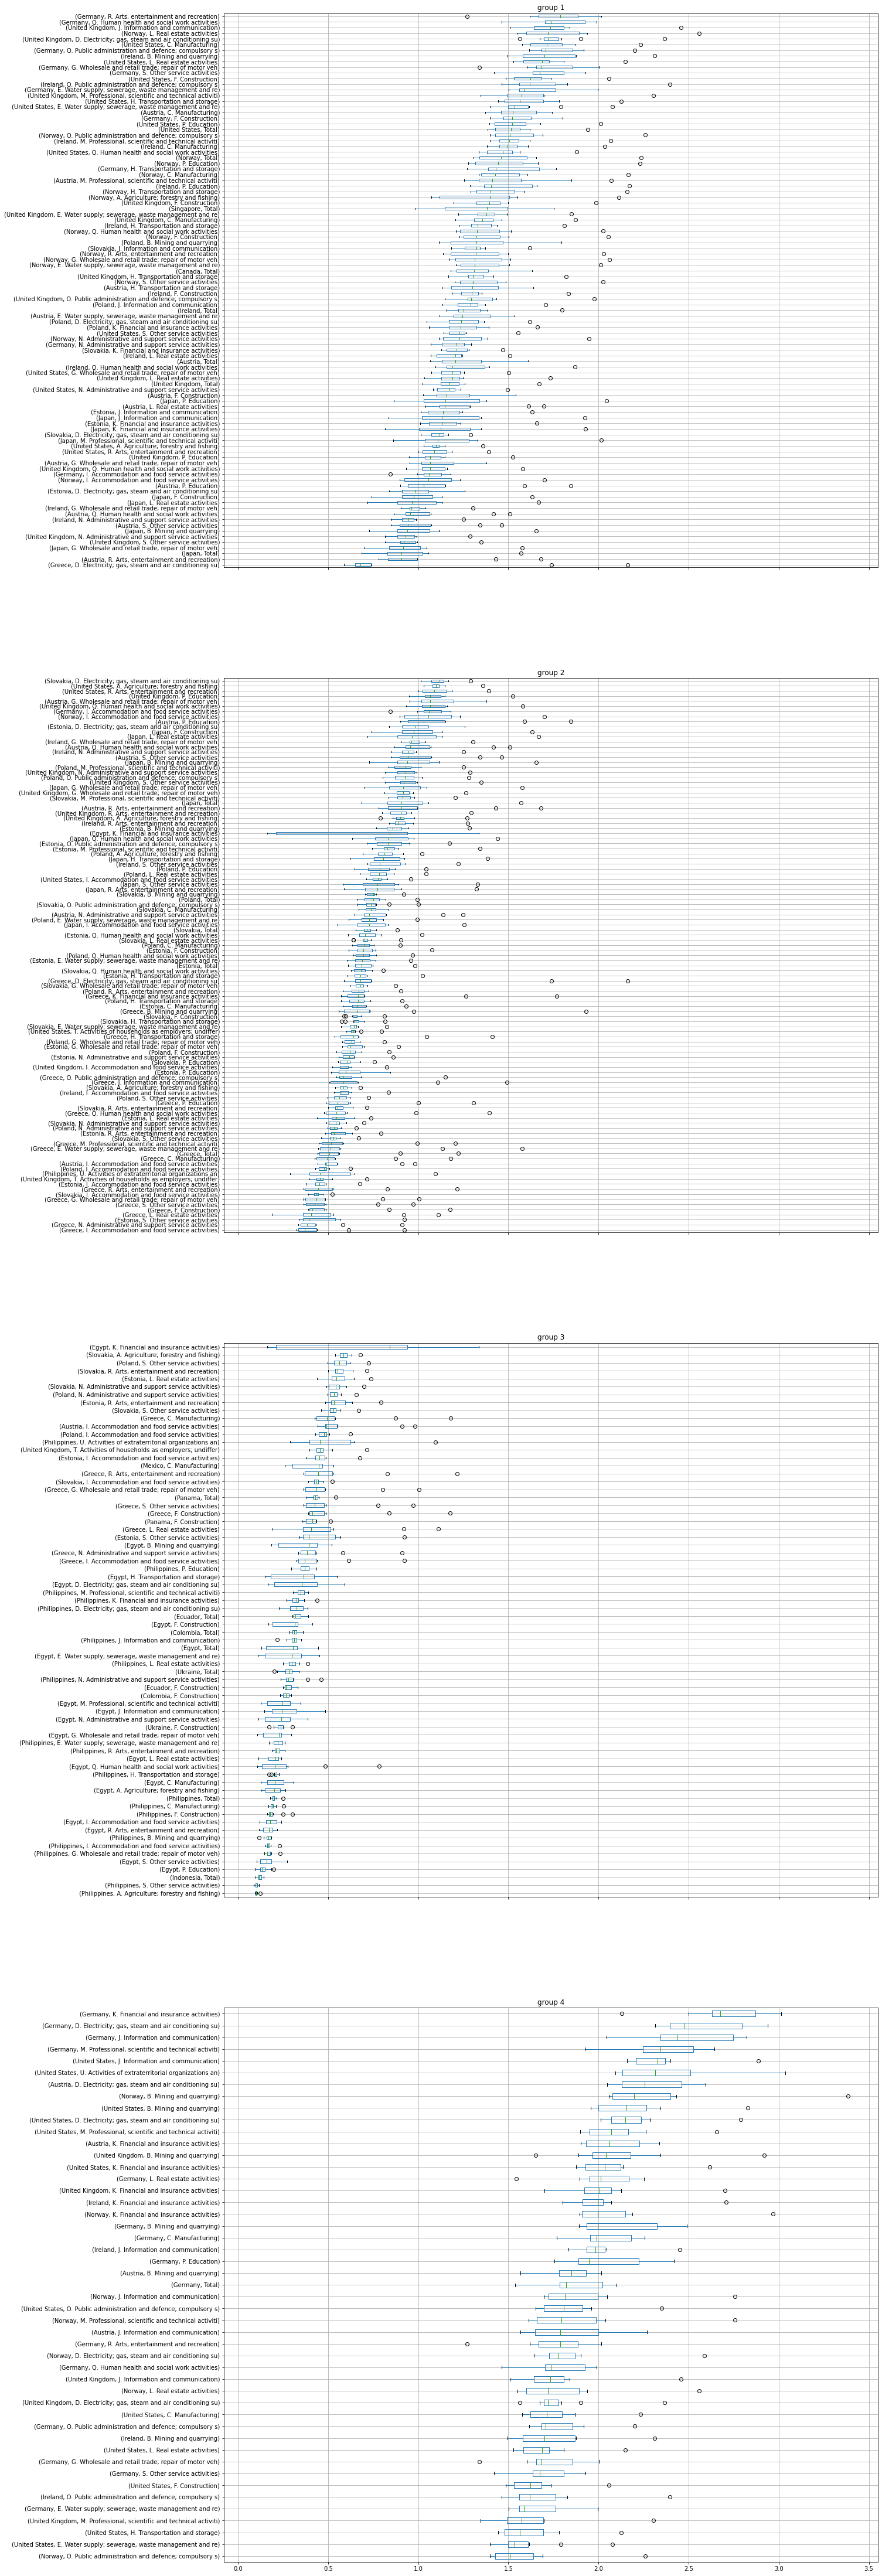

In [37]:
fig, axes = plt.subplots(wealth_factor_labels.columns.shape[0], figsize=(20,80),sharex=True)

for column,ax in zip(wealth_factor_labels.columns, axes):
    data = df_wealth_factor[wealth_factor_labels[column]]
    sort_by_mean = data.median(axis=1).sort_values()
    ax.title.set_text(column)
    data.reindex(sort_by_mean.index, axis=0).T.boxplot(vert=False,ax=ax)

In [48]:
wealth_factor_labels.to_csv("dataset//wealth_factor_labels.csv")

Bibliografia:
* Cluster Analysis of Economic Data